# FairPredictor XGBoost Examples
This file contains demo code for an extended version of the example in Readme.md (additionally handling more fairness over multiple groups), and enforcing a range of fairness definition on COMPAS.

It is a modified version of [quickstart_autogluon.ipynb](./quickstart_autogluon.ipynb)

FairPredictor is a postprocessing approach for enforcing fairness, with support for a wide range of performance metrics and fairness criteria, and support for inferred attributes, i.e., it does not require access to protected attributes at test time. 
Under the hood, FairPredictor works by adjusting the decision boundary for each group individually. Where groups are not available, it makes use of inferred group membership to adjust decision boundaries.

The key idea underlying this toolkit is that for a wide range of use cases, the most suitable classifier should do more than maximize some form of accuracy.
We offer a general toolkit that allows different measures to be optimized and additional constraints to be imposed by tuning the behavior of a binary predictor on validation data.

For example, classifiers can be tuned to maximize performance for a wide range of metrics such as:

* Accuracy
* Balanced Accuracy
* F1 score
* MCC
* Custom utility functions

While also approximately satisfying a wide range of group constraints such as:

* Demographic Parity (The idea that positive decisions should occur at the same rates for all protected groups, for example for men at the same rate as for women)
* Equal Opportunity (The recall should be the same for all protected groups)
* Minimum recall constraints (The recall should be above a particular level for all groups)
* Minimum Precision constraints (The precision should be above a particular level for all groups)
* Custom Fairness Metrics

The full set of constraints and objectives can be seen in Readme.md 

In [1]:
# Load data and train a baseline classifier

from oxonfair import dataset_loader, FairPredictor
from oxonfair import group_metrics as gm
import xgboost
import pandas as pd
import numpy as np


train_data, val_data, test_data = dataset_loader.adult('sex',seed=0)
predictor=xgboost.XGBClassifier().fit(X=train_data['data'],y=train_data['target'])

/opt/miniconda3/envs/ag/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Modify predictor to enforce fairness over the val_data with respect to groups given by the column 'sex'. 
# Note that 'sex' is implied because the dataset loader creates DataDict with val_data['groups' ]='sex'
fpredictor = FairPredictor(predictor,val_data)
# Maximize accuracy while enforcing that the demographic parity (the difference in positive decision rates between men and women is at most 0.02)
fpredictor.fit(gm.accuracy,gm.demographic_parity,0.02)


In [4]:
# Evaluate on test data
fpredictor.predict(test_data)

array([0, 0, 0, ..., 0, 0, 0])

In [5]:
# Evaluate a range of performance measures, and compare against original classifier on test data
fpredictor.evaluate(test_data, verbose=True)

,original,updated
Accuracy,0.868070,0.846450
Balanced Accuracy,0.792829,0.738389
F1 score,0.701722,0.623418
MCC,0.621197,0.543507
Precision,0.764421,0.754497
Recall,0.648528,0.531143
ROC AUC,0.924859,0.815935


In [6]:
# Evaluate against a range of standard fairness definitions and compare against original classifier on test data
fpredictor.evaluate_fairness(test_data, verbose=True)

,original,updated
Statistical Parity,0.177305,0.002921
Predictive Parity,0.021817,0.358664
Equal Opportunity,0.084367,0.296515
Average Group Difference in False Negative Rate,0.084367,0.296515
Equalized Odds,0.073847,0.178165
Conditional Use Accuracy,0.055377,0.259058
Average Group Difference in Accuracy,0.096100,0.073010
Treatment Equality,0.126426,3.277734


In [7]:
# Evaluate a range of performance measures per group, and compare against original classifier on test data
fpredictor.evaluate_groups(test_data, verbose=True, return_original=True)

Accuracy  Balanced Accuracy  F1 score       MCC  \
         Groups                                                                
original Overall             0.868070           0.792829  0.701722  0.621197   
         0                   0.932312           0.776398  0.650510  0.619903   
         1                   0.836212           0.786918  0.710418  0.600324   
         Maximum difference  0.096100           0.010520  0.059908  0.019578   
updated  Overall             0.846450           0.738389  0.623418  0.543507   
         0                   0.895257           0.845923  0.620072  0.579203   
         1                   0.822247           0.727572  0.624385  0.558005   
         Maximum difference  0.073010           0.118351  0.004314  0.021198   

                             Precision    Recall   ROC AUC  Positive Count  \
         Groups                                                              
original Overall              0.764421  0.648528  0.924859          2922.0   
         0                    0.745614  0.576923  0.938317           442.0   
         1                    0.767431  0.661290  0.908558          2480.0   
         Maximum difference   0.021817  0.084367  0.029759          2038.0   
updated  Overall              0.754497  0.531143  0.815935          2922.0   
         0                    0.513353  0.782805  0.938317           442.0   
         1                    0.872017  0.486290  0.908558          2480.0   
         Maximum difference   0.358664  0.296515  0.029759          2038.0   

                             Negative Count  Positive Label Rate  \
         Groups                                                    
original Overall                     9289.0             0.239292   
         0                           3606.0             0.109190   
         1                           5683.0             0.303810   
         Maximum difference          2077.0             0.194620   
updated  Overall                     9289.0             0.239292   
         0                           3606.0             0.109190   
         1                           5683.0             0.303810   
         Maximum difference          2077.0             0.194620   

                             Positive Prediction Rate  
         Groups                                        
original Overall                             0.203014  
         0                                   0.084486  
         1                                   0.261791  
         Maximum difference                  0.177305  
updated  Overall                             0.168455  
         0                                   0.166502  
         1                                   0.169423  
         Maximum difference                  0.002921

In [8]:
# Now let's enforce fairness with respect to  the column lablled 'race'.
# We will override the default use of 'sex' as groups by specifying that 'race' should be used instead
# This will generate a warning.
fpredictor = FairPredictor(predictor,val_data,'race') 

# Maximize accuracy while enforcing that the demographic parity (the difference in positive decision rates between men and women is at most 0.02)
fpredictor.fit(gm.accuracy, gm.demographic_parity, .02)

Groups passed twice to fairpredictor both as part of the dataset and as an argument. The argument will be used.


In [9]:
# Unlike the previous case, we find that demographic parity is still high on test data, although it is improved.
fpredictor.evaluate_fairness(test_data)

,original,updated
Statistical Parity,0.086588,0.025954
Predictive Parity,0.109883,0.298558
Equal Opportunity,0.103536,0.239243
Average Group Difference in False Negative Rate,0.103536,0.239243
Equalized Odds,0.067798,0.149357
Conditional Use Accuracy,0.078884,0.189482
Average Group Difference in Accuracy,0.048359,0.076684
Treatment Equality,0.235925,2.580855


In [10]:
fpredictor.evaluate_fairness()

,original,updated
Statistical Parity,0.103798,0.019067
Predictive Parity,0.048711,0.185250
Equal Opportunity,0.203456,0.121149
Average Group Difference in False Negative Rate,0.203456,0.121149
Equalized Odds,0.120177,0.074532
Conditional Use Accuracy,0.036709,0.123828
Average Group Difference in Accuracy,0.035635,0.045224
Treatment Equality,0.314151,0.807986


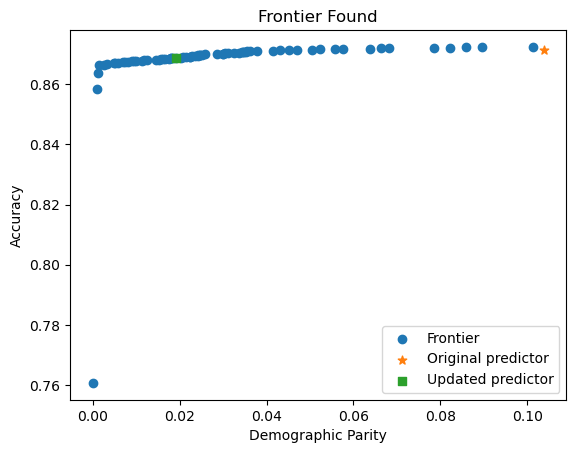

In [11]:
#To debug this, we can look at the Pareto Frontier of solutions considered, on the validation set
fpredictor.plot_frontier() 

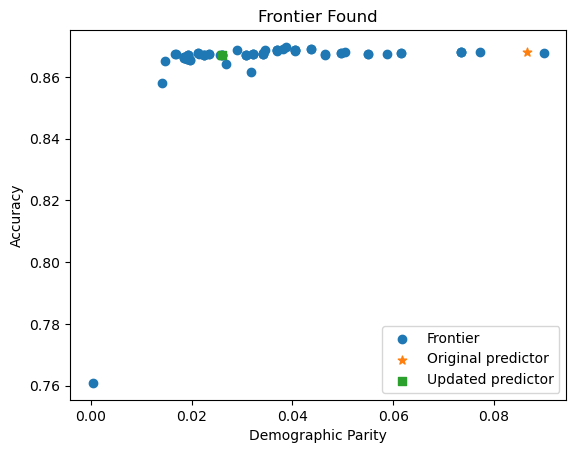

In [12]:
#and on the test set
fpredictor.plot_frontier(test_data) 

In [13]:
#We find that the demographic parity is very different on test data for a range of solutions found.
#By looking at the per group decomposition, we can find out why.
fpredictor.evaluate_groups(test_data)

Accuracy  Balanced Accuracy  F1 score       MCC  \
         Groups                                                                
original Overall             0.868070           0.792829  0.701722  0.621197   
         0                   0.918182           0.702420  0.470588  0.427288   
         1                   0.828042           0.753123  0.652406  0.546140   
         2                   0.919105           0.740020  0.601695  0.572078   
         3                   0.920792           0.738764  0.600000  0.572134   
         4                   0.862811           0.795922  0.709573  0.623438   
         Maximum difference  0.092750           0.093502  0.238985  0.196150   
updated  Overall             0.867251           0.769771  0.677541  0.609446   
         0                   0.790909           0.633113  0.258065  0.182423   
         1                   0.833333           0.729927  0.622754  0.551044   
         2                   0.917384           0.846014  0.688312  0.644134   
         3                   0.940594           0.930243  0.785714  0.762536   
         4                   0.863002           0.768358  0.681059  0.613950   
         Maximum difference  0.149685           0.297130  0.527650  0.580113   

                             Precision    Recall   ROC AUC  Positive Count  \
         Groups                                                              
original Overall              0.764421  0.648528  0.924859          2922.0   
         0                    0.500000  0.444444  0.840484             9.0   
         1                    0.734940  0.586538  0.896126           104.0   
         2                    0.747368  0.503546  0.942818           141.0   
         3                    0.750000  0.500000  0.962547            12.0   
         4                    0.767177  0.660015  0.922721          2656.0   
         Maximum difference   0.267177  0.215571  0.122063          2647.0   
updated  Overall              0.809026  0.582820  0.900809          2922.0   
         0                    0.181818  0.444444  0.840484             9.0   
         1                    0.825397  0.500000  0.896126           104.0   
         2                    0.634731  0.751773  0.942818           141.0   
         3                    0.687500  0.916667  0.962547            12.0   
         4                    0.832880  0.576054  0.922721          2656.0   
         Maximum difference   0.651062  0.472222  0.122063          2647.0   

                             Negative Count  Positive Label Rate  \
         Groups                                                    
original Overall                     9289.0             0.239292   
         0                            101.0             0.081818   
         1                            274.0             0.275132   
         2                           1021.0             0.121343   
         3                             89.0             0.118812   
         4                           7804.0             0.253920   
         Maximum difference          7715.0             0.193314   
updated  Overall                     9289.0             0.239292   
         0                            101.0             0.081818   
         1                            274.0             0.275132   
         2                           1021.0             0.121343   
         3                             89.0             0.118812   
         4                           7804.0             0.253920   
         Maximum difference          7715.0             0.193314   

                             Positive Prediction Rate  
         Groups                                        
original Overall                             0.203014  
         0                                   0.072727  
         1                                   0.219577  
         2                                   0.081756  
         3                                   0.079208  
         4        

In [14]:
#The groups 0 and 1 corresponding American-Indian-Eskimo, and Asian-Pacific-Islander 
# only have around 100 samples making it impossible to accurately evaluate demographic parity, while the
# group 3 correpsonding to 'Other' have even less data.
# Moreover, on validation data we find that there are 94 people belonging to group 3, 
# meaning that it is not possible to predict if the positive prediction rate will hold on new data. 
fpredictor.evaluate_groups()

Accuracy  Balanced Accuracy  F1 score       MCC  \
         Groups                                                                
original Overall             0.871417           0.796558  0.708504  0.630531   
         0                   0.898148           0.637538  0.421053  0.439721   
         1                   0.859043           0.803402  0.722513  0.630335   
         2                   0.931323           0.772184  0.661157  0.636117   
         3                   0.893617           0.712340  0.583333  0.571971   
         4                   0.864533           0.797005  0.712016  0.627521   
         Maximum difference  0.072281           0.165864  0.301460  0.196396   
updated  Overall             0.868796           0.772199  0.681638  0.614351   
         0                   0.851852           0.732523  0.500000  0.419147   
         1                   0.843085           0.745509  0.646707  0.572099   
         2                   0.924623           0.847574  0.701987  0.660555   
         3                   0.914894           0.849359  0.750000  0.698718   
         4                   0.863096           0.769511  0.682374  0.614266   
         Maximum difference  0.081538           0.116836  0.250000  0.279571   

                             Precision    Recall   ROC AUC  Positive Count  \
         Groups                                                              
original Overall              0.774351  0.652977  0.923992          2922.0   
         0                    0.800000  0.285714  0.845745            14.0   
         1                    0.766667  0.683168  0.915248           101.0   
         2                    0.800000  0.563380  0.958081           142.0   
         3                    0.875000  0.437500  0.959135            16.0   
         4                    0.773109  0.659872  0.919773          2649.0   
         Maximum difference   0.108333  0.397454  0.113390          2635.0   
updated  Overall              0.812796  0.586927  0.900140          2922.0   
         0                    0.444444  0.571429  0.845745            14.0   
         1                    0.818182  0.534653  0.915248           101.0   
         2                    0.662500  0.746479  0.958081           142.0   
         3                    0.750000  0.750000  0.959135            16.0   
         4                    0.829730  0.579464  0.919773          2649.0   
         Maximum difference   0.385285  0.215347  0.113390          2635.0   

                             Negative Count  Positive Label Rate  \
         Groups                                                    
original Overall                     9288.0             0.239312   
         0                             94.0             0.129630   
         1                            275.0             0.268617   
         2                           1052.0             0.118928   
         3                             78.0             0.170213   
         4                           7789.0             0.253784   
         Maximum difference          7711.0             0.149689   
updated  Overall                     9288.0             0.239312   
         0                             94.0             0.129630   
         1                            275.0             0.268617   
         2                           1052.0             0.118928   
         3                             78.0             0.170213   
         4                           7789.0             0.253784   
         Maximum difference          7711.0             0.149689   

                             Positive Prediction Rate  
         Groups                                        
original Overall                             0.201802  
         0                                   0.046296  
         1                                   0.239362  
         2                                   0.083752  
         3                                   0.085106  
         4        

## Fairness on COMPAS using Inferred Attributes

We demonstrate how to enforce a wide range of fairness definitions on the COMPAS dataset. This dataset records paroles caught violating the terms of parole. As it measures who was caught, it is strongly influenced by policing and environmental biases, and should not be confused with a measurement of who actually violated their terms of parole. See [this paper](https://datasets-benchmarks-proceedings.neurips.cc/paper/2021/file/92cc227532d17e56e07902b254dfad10-Paper-round1.pdf) for a discussion of its limitations and caveats. 
We use it because it is a standard fairness dataset that captures such strong differences in outcome between people identified as African-American and everyone else, that classifiers trained on this dataset violate most definitions of fairness.

As many of the ethnic groups are too small for reliable statistical estimation, we only consider differences is in outcomes between African-Americans vs. everyone else (labeled as other).
We load and preprocess the COMPAS dataset, splitting it into three roughly equal partitions of train, validation, and test:

In [15]:
#Generate two sets of training, validation and test, with race and without.
train, val, test = dataset_loader.compas('race', train_proportion=0.66, test_proportion=0.33, discard_groups=True, replace_groups={'Hispanic':'Other', 'Native American':'Other', 'Asian':'Other'})
train_g, val_g, test_g = dataset_loader.compas('race', train_proportion=0.66, test_proportion=0.33, replace_groups={'Hispanic':'Other', 'Native American':'Other', 'Asian':'Other'})

In [16]:
predictor = xgboost.XGBClassifier().fit(X=train_g['data'],y=train_g['target'])
predictor2 = xgboost.XGBClassifier().fit(X=train['data'],y=train['target'])
protected = xgboost.XGBClassifier().fit(X=train['data'],y=2*(train['groups']=='Other')+(train['groups']=='Caucasian'))

In [17]:
fpredictor=FairPredictor(predictor2, train, inferred_groups=protected)
fpredictor.fit(gm.accuracy, gm.demographic_parity, 0.025)

In [18]:
#However, instead we will show how a family of fairness measures can be individually optimized. 
# The following code plots a table showing the change in accuracy and the fairness measure on a held-out test set as we decrease
# the fairness measure to less than 0.025 for all measures except for disparate impact which we raise to above 0.975.
# We define a helper function for evaluation:

def evaluate(fpredictor, use_metrics, test):
    "Print a table showing the accuracy drop that comes with enforcing fairness"
    extra_metrics= {**use_metrics, 'accuracy':gm.accuracy}
    collect=pd.DataFrame(columns=['Measure (original)', 'Measure (updated)', 'Accuracy (original)', 'Accuracy (updated)'])
    for d in use_metrics.items():
        if d[1].greater_is_better is False:
            fpredictor.fit(gm.accuracy,d[1], 0.025)
        else:
            fpredictor.fit(gm.accuracy,d[1], 1-0.025)
        tmp=fpredictor.evaluate_fairness(test,metrics=extra_metrics)
        collect.loc[d[1].name]=np.concatenate((np.asarray(tmp.loc[d[1].name]), np.asarray(tmp.loc[gm.accuracy.name])), 0)
    return collect

In [19]:
train['data'].columns

Index(['sex', 'age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count',
       'priors_count', 'age_cat', 'c_charge_degree'],
      dtype='object')

In [20]:
#We can now contrast the behavior of a fair classifier that relies on access to the protected
# attribtute at test time with one that infers it.

#Create a fair predictor object, using the attribute 'race' on validation data
fpredictor = FairPredictor(predictor, train_g, 'race')
#and then evaluate it
true_groups = evaluate(fpredictor, gm.clarify_metrics, test_g)

true_groups

Groups passed twice to fairpredictor both as part of the dataset and as an argument. The argument will be used.
/Users/chris.russell/code/oxon-fair/src/oxonfair/utils/group_metric_classes.py:187: RuntimeWarning: divide by zero encountered in divide
  broadcast = val[:, np.newaxis, :] / val[:, :, np.newaxis]
/Users/chris.russell/code/oxon-fair/src/oxonfair/utils/group_metric_classes.py:187: RuntimeWarning: invalid value encountered in divide
  broadcast = val[:, np.newaxis, :] / val[:, :, np.newaxis]
/Users/chris.russell/code/oxon-fair/src/oxonfair/utils/group_metric_classes.py:188: RuntimeWarning: divide by zero encountered in divide
  trunc = np.minimum(broadcast, 1.0/broadcast)


,Measure (original),Measure (updated),Accuracy (original),Accuracy (updated)
Demographic Parity,0.143272,0.032289,0.665966,0.657983
Disparate Impact,0.676551,0.926650,0.665966,0.658403
Average Group Difference in Conditional Acceptance Rate,0.295479,0.149225,0.665966,0.663866
Average Group Difference in Conditional Rejectance Rate,0.073337,0.049720,0.665966,0.666387
Average Group Difference in Accuracy,0.020770,0.027879,0.665966,0.659664
Average Group Difference in Recall,0.141964,0.048725,0.665966,0.662185
Average Group Difference in Acceptance Rate,0.068012,0.042838,0.665966,0.664286
Average Group Difference in Specificity,0.102659,0.055465,0.665966,0.667647
Average Group Difference in Rejection Rate,0.067998,0.054255,0.665966,0.661345
Treatment Equality,0.246724,0.201742,0.665966,0.667227


In [21]:
 # Now using infered attributes
#Note that group information is not present in train['data']
#But contained in train['groups'] as such we can not specify groups='race'
fpredictor2 = FairPredictor(predictor2, train, inferred_groups=protected) 
inferred = evaluate(fpredictor2, gm.clarify_metrics, test)
inferred

/Users/chris.russell/code/oxon-fair/src/oxonfair/utils/group_metric_classes.py:187: RuntimeWarning: divide by zero encountered in divide
  broadcast = val[:, np.newaxis, :] / val[:, :, np.newaxis]
/Users/chris.russell/code/oxon-fair/src/oxonfair/utils/group_metric_classes.py:187: RuntimeWarning: invalid value encountered in divide
  broadcast = val[:, np.newaxis, :] / val[:, :, np.newaxis]
/Users/chris.russell/code/oxon-fair/src/oxonfair/utils/group_metric_classes.py:188: RuntimeWarning: divide by zero encountered in divide
  trunc = np.minimum(broadcast, 1.0/broadcast)


,Measure (original),Measure (updated),Accuracy (original),Accuracy (updated)
Demographic Parity,0.165571,0.092715,0.655042,0.616387
Disparate Impact,0.632857,0.739584,0.655042,0.613866
Average Group Difference in Conditional Acceptance Rate,0.312805,0.121341,0.655042,0.635294
Average Group Difference in Conditional Rejectance Rate,0.071236,0.043332,0.655042,0.651681
Average Group Difference in Accuracy,0.017547,0.020282,0.655042,0.653361
Average Group Difference in Recall,0.168021,0.111140,0.655042,0.621849
Average Group Difference in Acceptance Rate,0.060030,0.072319,0.655042,0.662185
Average Group Difference in Specificity,0.116554,0.077059,0.655042,0.655882
Average Group Difference in Rejection Rate,0.049767,0.052664,0.655042,0.650840
Treatment Equality,0.267860,0.153486,0.655042,0.650840


In [22]:
fpredictor2.evaluate_groups(test)

Accuracy  Balanced Accuracy  F1 score       MCC  \
         Groups                                                                
original Overall             0.655042           0.644959  0.586398  0.296724   
         African-American    0.648893           0.649451  0.648604  0.298917   
         Caucasian           0.655556           0.617054  0.499102  0.251110   
         Other               0.675214           0.610851  0.457143  0.250721   
         Maximum difference  0.026321           0.038600  0.191461  0.048197   
updated  Overall             0.650840           0.637129  0.562401  0.286669   
         African-American    0.644791           0.646831  0.625108  0.296202   
         Caucasian           0.651852           0.608508  0.477778  0.238053   
         Other               0.669516           0.599568  0.431373  0.231235   
         Maximum difference  0.024725           0.047264  0.193736  0.064967   

                             Precision    Recall   ROC AUC  Positive Count  \
         Groups                                                              
original Overall              0.638158  0.542404  0.696316          1073.0   
         African-American     0.668359  0.629984  0.696279           627.0   
         Caucasian            0.584034  0.435737  0.669486           319.0   
         Other                0.578313  0.377953  0.688660           127.0   
         Maximum difference   0.090045  0.252031  0.026792           500.0   
updated  Overall              0.646489  0.497670  0.681000          1073.0   
         African-American     0.683712  0.575758  0.684535           627.0   
         Caucasian            0.583710  0.404389  0.652057           319.0   
         Other                0.571429  0.346457  0.662841           127.0   
         Maximum difference   0.112284  0.229301  0.032478           500.0   

                             Negative Count  Positive Label Rate  \
         Groups                                                    
original Overall                     1307.0             0.450840   
         African-American             592.0             0.514356   
         Caucasian                    491.0             0.393827   
         Other                        224.0             0.361823   
         Maximum difference           368.0             0.152533   
updated  Overall                     1307.0             0.450840   
         African-American             592.0             0.514356   
         Caucasian                    491.0             0.393827   
         Other                        224.0             0.361823   
         Maximum difference           368.0             0.152533   

                             Positive Prediction Rate  
         Groups                                        
original Overall                             0.383193  
         African-American                    0.484824  
         Caucasian                           0.293827  
         Other                               0.236467  
         Maximum difference                  0.248356  
updated  Overall                             0.347059  
         African-American                    0.433142  
         Caucasian                           0.272840  
         Other                               0.219373  
         Maximum difference                  0.213769

In [23]:
from oxonfair import conditional_group_metrics as cgm
fpredictor2_cond = FairPredictor(predictor2, train, inferred_groups=protected,conditioning_factor='sex') 
fpredictor2_cond.fit(gm.accuracy,cgm.pos_pred_rate.diff,0.02)

In [24]:
fpredictor2_cond.evaluate(metrics={'a':gm.accuracy,'b':cgm.pos_pred_rate.diff})


,original,updated
Accuracy,0.737715,0.670307
Average Group Difference in Conditional Positive Prediction Rate,0.140402,0.019999


In [25]:
fpredictor2_cond.evaluate(test,metrics={'a':gm.accuracy,'b':cgm.pos_pred_rate.diff})


,original,updated
Accuracy,0.655042,0.615966
Average Group Difference in Conditional Positive Prediction Rate,0.166871,0.087709
